In [51]:
import os, pdb

from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import statsmodels.api as sm
from scipy.stats import ttest_ind

from case_types import cases_all

from statsmodels.formula.api import ols

In [14]:
graybox_root = '../run_methods_example/gray_box/result_csvs'
blackbox_root = '../run_methods_example/black_box/result_csvs'
sc_root = '../run_methods_example/surrogate_calibration' 

In [45]:
def oc_fname(case):
    return f'results_sc_{case[0]}_{case[1]}_{case[2]}.csv'

def bc_fname(case):
    return f'results_bcall_{case[0]}_{case[1]}_{case[2]}.csv'

def bp_fname(case):
    return f'bp_D_{case[0]}_{case[1]}_sched{case[2]}.csv'

def dc_fname(case):
    return f'dc_5T_{case[0]}_{case[1]}_sched{case[2]}.csv'

def rc1_fname(case):
    return f'rc_Ti2_dt_jan7_5_{case[0]}_{case[1]}_sched{case[2]}.csv'

def rc2_fname(case):
    return f'rc_TiTe1_dt_jan7_5_{case[0]}_{case[1]}_sched{case[2]}.csv'

def cnn0_fname(case):
    return f'5_cnn_1_{case[0]}_{case[1]}_sched{case[2]}.csv'

def rnn0_fname(case):
    return f'5_rnn_1_{case[0]}_{case[1]}_sched{case[2]}.csv'

def get_xy(df, pred_type):
    if pred_type == 'HLC':
        x, y = df['hlc_tot'] + df['hlc_inf_standard'], df['hlc_tot_pred']
    elif pred_type == 'RC':
        x, y = (df['c_tot']/300) /( df['hlc_tot'] + df['hlc_inf_current']), df['hlc_tot_pred']
    return x,y


def get_xy_blackbox(df, pred_type):
    x, y = df[pred_type], df[pred_type + '_pred']
    return x,y


def mape(xy): 
    """ Mean absolute percentage error """
    x, y = xy
    return np.mean(np.abs((x - y) / x)) #* 100


def linregress(xy):
    """ Returns Rsquared and Slope """
    x, y = xy
    X = sm.add_constant(x, has_constant='add')
    model = sm.OLS(y, X).fit()
    return model.rsquared, model

def case_string(case):
    case_name = ''
    for c in case:
        c = str(c)
#         if 'control' in c: c = c[8:]
#         if '_inf' in c: c=c[:-4]
#         if 'True' in c: c = 'Sched'
#         if 'False' in c: c = 'No Sched'
        case_name = case_name + c # + '\n'
    return case_name

def add_case_to_df(df, case):
    df['case'] = case_string(case)
    df['weather'] = case[0]
    if 'inf' in case[1]:
        df['construct'] = case[1][8:-4]
        df['infil'] = 'True'
    else:
        df['construct'] = case[1][8:]
        df['infil'] = 'False'
        
    df['sched'] = str(case[2])
    return df

In [57]:
# make sure order matches the other plots
cases_all = [
    ('chicago', 'control_concrete', False),
     ('chicago', 'control_concrete', True),
    ('chicago', 'control_concrete_inf', False),
     ('chicago', 'control_concrete_inf', True),
    
    ('chicago', 'control_wood', False),
     ('chicago', 'control_wood', True),
    ('chicago', 'control_wood_inf', False),
     ('chicago', 'control_wood_inf', True),

    ('victoria', 'control_concrete', False),
     ('victoria', 'control_concrete', True),
    ('victoria', 'control_concrete_inf', False),
     ('victoria', 'control_concrete_inf', True),
    
    ('victoria', 'control_wood', False),
     ('victoria', 'control_wood', True),
    ('victoria', 'control_wood_inf', False),
     ('victoria', 'control_wood_inf', True),
    
#      ('chicago', 'control_wood', False),
#      ('chicago', 'control_wood', True),
    
#      ('victoria', 'control_concrete', False),
#      ('victoria', 'control_concrete', True),
#      ('victoria', 'control_wood', False),
#      ('victoria', 'control_wood', True),
     
#      ('victoria', 'control_concrete_inf', False),
#      ('victoria', 'control_concrete_inf', True),
#      ('victoria', 'control_wood_inf', False),
#      ('victoria', 'control_wood_inf', True),
     
#      ('chicago', 'control_wood_inf', False),
#      ('chicago', 'control_wood_inf', True)
]

In [75]:
bp_results = OrderedDict()
dc_results = OrderedDict()
rc1_results = OrderedDict()
rc2_results = OrderedDict()
oc_results = OrderedDict()
bc_results = OrderedDict()
rnn0_results = OrderedDict()
cnn0_results = OrderedDict()


bp_results_list = []
dc_results_list = []
rc1_results_list = []
rc2_results_list = []
oc_results_list = []
bc_results_list = []
rnn0_results_list = []
cnn0_results_list = []


for case in cases_all:
    # Balance Points
    bp_pth = os.path.join(graybox_root, bp_fname(case))
    bp_df  = pd.read_csv(bp_pth).dropna() 
    x, y   = get_xy(bp_df, 'HLC')
#     bp_df['abs_err'] = np.abs((x - y) / x)
    bp_df['abs_err'] = np.abs(x - y)
    bp_results[case] = bp_df
    bp_df = add_case_to_df(bp_df, case)
    bp_results_list.append(bp_df)
    
    # Decay Curve
    dc_pth = os.path.join(graybox_root, dc_fname(case))
    dc_df  = pd.read_csv(dc_pth).dropna()  
    x, y  = get_xy(dc_df, 'RC')
    dc_df['abs_err'] = np.abs((x - y) / x)
    dc_results[case] = dc_df
    bp_df = add_case_to_df(dc_df, case)
    dc_results_list.append(dc_df)
    
    # RC 1
    try:
        rc_pth = os.path.join(graybox_root, rc1_fname(case))
        rc_df  = pd.read_csv(rc_pth).dropna() 
        x, y  = get_xy(rc_df, 'HLC')
#         rc_df['abs_err'] = np.abs((x - y) / x)
        rc_df['abs_err'] = np.abs(x - y)
        rc1_results[case] = rc_df
        rc_df = add_case_to_df(rc_df, case)
        rc1_results_list.append(rc_df)
    except KeyError:
        print(case)
        
    # RC 2
    try:
        rc_pth = os.path.join(graybox_root, rc2_fname(case))
        rc_df  = pd.read_csv(rc_pth).dropna() 
        x, y  = get_xy(rc_df, 'HLC')
#         rc_df['abs_err'] = np.abs((x - y) / x)
        rc_df['abs_err'] = np.abs(x - y)
        rc2_results[case] = rc_df
        rc_df = add_case_to_df(rc_df, case)
        rc2_results_list.append(rc_df)
    except KeyError:
        print(case)
        
    # Optimization Calibration
    oc_pth = os.path.join(sc_root, oc_fname(case))
    oc_df  = pd.read_csv(oc_pth, index_col='Unnamed: 0').dropna() 
    x, y   = oc_df.true, oc_df.pred
#     oc_df['abs_err'] = np.abs((x - y) / x)
    oc_df['abs_err'] = np.abs(x - y)
    oc_results[case] = oc_df
    oc_df = add_case_to_df(oc_df, case)
    oc_results_list.append(oc_df)
        
    # Bayesian Calibration
    bc_pth = os.path.join(sc_root, bc_fname(case))
    bc_df  = pd.read_csv(bc_pth, index_col='Unnamed: 0').dropna() 
    x, y   = bc_df.true, bc_df.pred
#     bc_df['abs_err'] = np.abs((x - y) / x)
    bc_df['abs_err'] = np.abs(x - y)
    bc_results[case] = bc_df
    bc_df = add_case_to_df(bc_df, case)
    bc_results_list.append(bc_df)

    
    # RNN
    rnn0_pth = os.path.join(blackbox_root, rnn0_fname(case))
    rnn0_df  = pd.read_csv(rnn0_pth).dropna()
    x, y  = get_xy_blackbox(rnn0_df, 'envelope_inf_hlc')
#     rnn0_df['abs_err'] = np.abs((x - y) / x)
    rnn0_df['abs_err'] = np.abs(x - y)
    rnn0_results[case] = rnn0_df
    rnn0_df = add_case_to_df(rnn0_df, case)
    rnn0_results_list.append(rnn0_df)
    
    # CNN
    cnn0_pth = os.path.join(blackbox_root, cnn0_fname(case))
    cnn0_df  = pd.read_csv(cnn0_pth).dropna()    
    x, y  = get_xy_blackbox(cnn0_df, 'envelope_inf_hlc')
#     cnn0_df['abs_err'] = np.abs((x - y) / x)
    cnn0_df['abs_err'] = np.abs(x - y)
    cnn0_results[case] = cnn0_df
    cnn0_df = add_case_to_df(cnn0_df, case)
    cnn0_results_list.append(cnn0_df)
    
    
bp_results_df = pd.concat(bp_results_list)
dc_results_df = pd.concat(dc_results_list)
rc1_results_df = pd.concat(rc1_results_list)
rc2_results_df = pd.concat(rc2_results_list)
rnn0_results_df = pd.concat(rnn0_results_list)
cnn0_results_df = pd.concat(cnn0_results_list)


# all_result_dfs =  [bp_results_df, dc_results_df, rc_results_df, rnn0_results_df, cnn0_results_df]

# named_results = {
#     'Balance Points': bp_results,
#     'RNN': rnn0_results,
#     'Decay Curves': dc_results,
#     'White Box Calibration': None,
#     'CTSM RC': rc_results,
#     'CNN': cnn0_results,
#     'Bayesian Calibration': None,
#     'Surrogate Calibration': None
# }

named_results = {
    'Energy Signature': bp_results,
    'RC Order 1': rc1_results,
    'RC Order 2': rc2_results,
    'Optimization\nCalibration': oc_results,
    'Bayesian\nCalibration': bc_results,
    'RNN': rnn0_results,
    'CNN': cnn0_results,
#     'Surrogate Calibration': None
}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



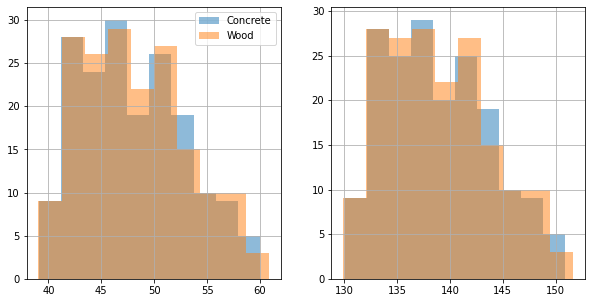

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

l = bp_results[cases_all[0]]['hlc_tot'] + bp_results[cases_all[0]]['hlc_inf_current']
l.hist(ax=axes[0], alpha=0.5, label='Concrete')

l = bp_results[cases_all[4]]['hlc_tot'] + bp_results[cases_all[4]]['hlc_inf_current']
l.hist(ax=axes[0], alpha=0.5, label='Wood')

axes[0].legend()


l = bp_results[cases_all[2]]['hlc_tot'] + bp_results[cases_all[2]]['hlc_inf_current']
l.hist(ax=axes[1], alpha=0.5, label='Concrete')

l = bp_results[cases_all[6]]['hlc_tot'] + bp_results[cases_all[6]]['hlc_inf_current']
l.hist(ax=axes[1], alpha=0.5)

In [123]:
(bp_results[cases_all[3]]['hlc_tot']  + bp_results[cases_all[3]]['hlc_inf_current'] ).max()

151.06526245395878

In [89]:
cases_all

[('chicago', 'control_concrete', False),
 ('chicago', 'control_concrete', True),
 ('chicago', 'control_concrete_inf', False),
 ('chicago', 'control_concrete_inf', True),
 ('chicago', 'control_wood', False),
 ('chicago', 'control_wood', True),
 ('chicago', 'control_wood_inf', False),
 ('chicago', 'control_wood_inf', True),
 ('victoria', 'control_concrete', False),
 ('victoria', 'control_concrete', True),
 ('victoria', 'control_concrete_inf', False),
 ('victoria', 'control_concrete_inf', True),
 ('victoria', 'control_wood', False),
 ('victoria', 'control_wood', True),
 ('victoria', 'control_wood_inf', False),
 ('victoria', 'control_wood_inf', True)]

In [76]:
cases_all

[('chicago', 'control_concrete', False),
 ('chicago', 'control_concrete', True),
 ('chicago', 'control_concrete_inf', False),
 ('chicago', 'control_concrete_inf', True),
 ('chicago', 'control_wood', False),
 ('chicago', 'control_wood', True),
 ('chicago', 'control_wood_inf', False),
 ('chicago', 'control_wood_inf', True),
 ('victoria', 'control_concrete', False),
 ('victoria', 'control_concrete', True),
 ('victoria', 'control_concrete_inf', False),
 ('victoria', 'control_concrete_inf', True),
 ('victoria', 'control_wood', False),
 ('victoria', 'control_wood', True),
 ('victoria', 'control_wood_inf', False),
 ('victoria', 'control_wood_inf', True)]

In [77]:
case_names = [
    'Chicago, Concrete',
    'Chicago, Concrete, Schedules',
    'Chicago, Concrete, Infiltration',
    'Chicago, Concrete, Infiltration, Schedules',
    
    'Chicago, Wood',
    'Chicago, Wood, Schedules',
    'Chicago, Wood, Infiltration',
    'Chicago, Wood, Infiltration, Schedules',
    
    'Victoria, Concrete',
    'Victoria, Concrete, Schedules',
    'Victoria, Concrete, Infiltration',
    'Victoria, Concrete, Infiltration, Schedules',
    
    'Victoria, Wood',
    'Victoria, Wood, Schedules',
    'Victoria, Wood, Infiltration',
    'Victoria, Wood, Infiltration, Schedules',
]

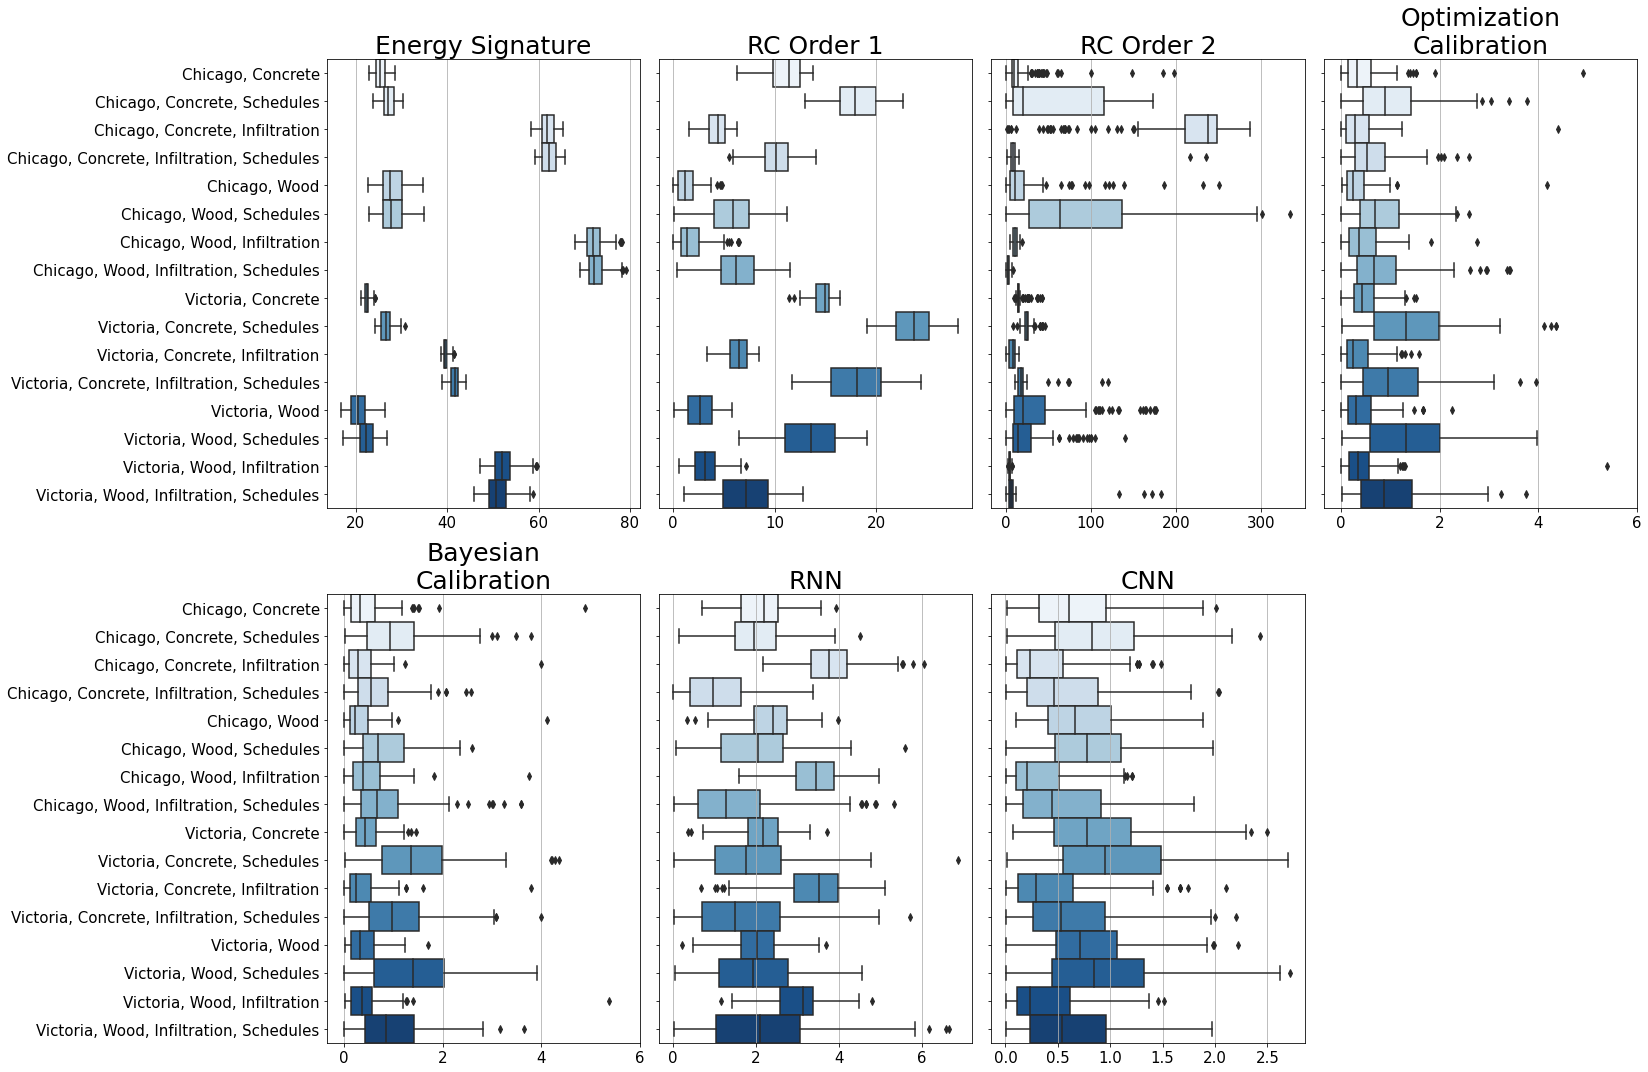

In [114]:
def create_boxplots(y='case', figsize=(23,15)):
    upper = 4

    fig, axes = plt.subplots(2, upper, sharey=True, figsize=figsize)

    i, j = 0,0
    for name, results in named_results.items():
        if results is not None:

            df_errs_all = pd.DataFrame()
            order = []
            for case, df in results.items():
                df_errors = pd.DataFrame()
                df_errors['errs'] = df['abs_err']
                case_name = case_string(case)
                df_errors = add_case_to_df(df_errors, case)
                df_errs_all = df_errs_all.append(df_errors)

            p1=sns.boxplot(x='errs', y=y, data=df_errs_all, ax=axes[i, j], width=1, palette='Blues')
            axes[i,j].set_ylabel('')
            axes[i,j].set_xlabel('')

        axes[i, j].set_title(name, fontsize=25)
        axes[i, j].xaxis.grid()
        axes[i, j].tick_params(axis='both',labelsize=15)
        axes[-1, -1].axis('off')
        
        plt.setp(axes[0,0], yticklabels=case_names)
        

        # cut off outliers from calibration for readability
        axes[1,0].set_xlim( (-0.35,6))
        axes[0,-1].set_xlim((-0.35,6))
        
        j+=1
        if j%upper == 0:
            i+=1; j=0

    plt.tight_layout()
    plt.savefig('boxplots_all')
    
create_boxplots()

In [124]:
def create_boxplots_small(y='case', figsize=(23,12)):
    upper = 4

    fig, axes = plt.subplots(2, upper, sharey=True, figsize=figsize)

    i, j = 0,0
    for name, results in named_results.items():
        if results is not None:

            df_errs_all = pd.DataFrame()
            order = []
            for case, df in results.items():
                df_errors = pd.DataFrame()
                df_errors['errs'] = df['abs_err']
                case_name = case_string(case)
#                 order.append(case_name)
#                 df_errors['name'] = case_name
                df_errors = add_case_to_df(df_errors, case)
                df_errs_all = df_errs_all.append(df_errors)

#             pdb.set_trace()
            p1=sns.boxplot(x='errs', y=y, data=df_errs_all, ax=axes[i, j], width=0.75)
#             p1=sns.boxplot(x='errs', y=y, data=df_errs_all, order=order, ax=axes[i, j], width=1)

        axes[i, j].set_title(name, fontsize=15)
        axes[i, j].xaxis.grid()
        axes[i, j].tick_params(axis='both',labelsize=10)

        j+=1
        if j%upper == 0:
            i+=1; j=0

    plt.tight_layout()

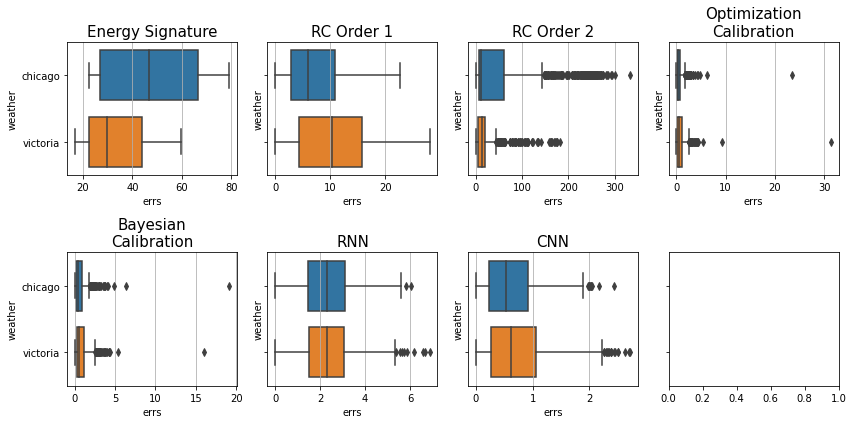

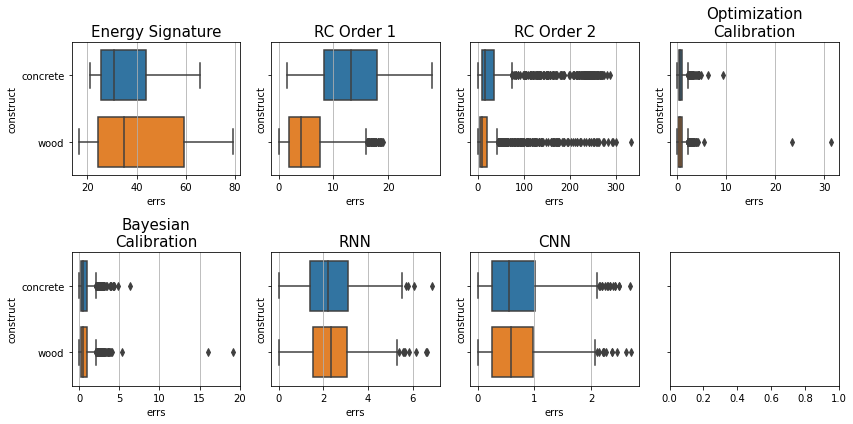

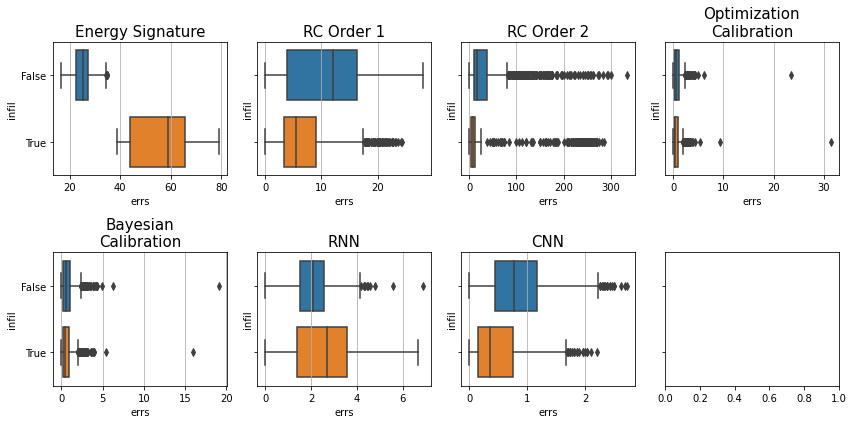

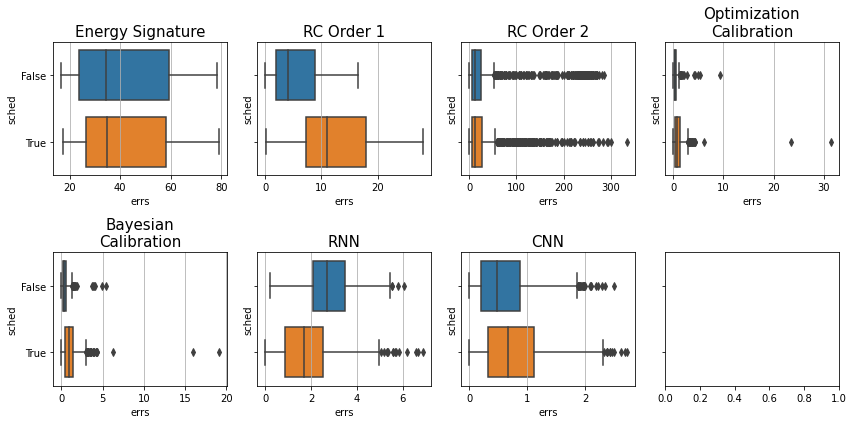

In [125]:
create_boxplots_small('weather', figsize=(12,6))
create_boxplots_small('construct', figsize=(12,6))
create_boxplots_small('infil', figsize=(12,6))
create_boxplots_small('sched', figsize=(12,6))

# Case by Case boxplotss

In [128]:
# NEW DICT to change the order so it matches the paper
# named_results = {
#     'Balance Points': bp_results,
#     'Decay Curves': dc_results,
#     'CTSM RC': rc_results,
#     'RNN': rnn0_results,
#     'CNN': cnn0_results,
#     'White Box Calibration': None,
#     'Bayesian Calibration': None,
#     'Surrogate Calibration': None
# }

          errs                          case   weather construct  infil  sched
0    27.813625  chicagocontrol_concreteFalse   chicago  concrete  False  False
1    25.387344  chicagocontrol_concreteFalse   chicago  concrete  False  False
2    26.461204  chicagocontrol_concreteFalse   chicago  concrete  False  False
3    23.598099  chicagocontrol_concreteFalse   chicago  concrete  False  False
4    23.258636  chicagocontrol_concreteFalse   chicago  concrete  False  False
..         ...                           ...       ...       ...    ...    ...
175  50.531728  victoriacontrol_wood_infTrue  victoria      wood   True   True
176  52.004622  victoriacontrol_wood_infTrue  victoria      wood   True   True
177  50.767963  victoriacontrol_wood_infTrue  victoria      wood   True   True
178  47.890361  victoriacontrol_wood_infTrue  victoria      wood   True   True
179  49.090577  victoriacontrol_wood_infTrue  victoria      wood   True   True

[2876 rows x 6 columns]
          errs             

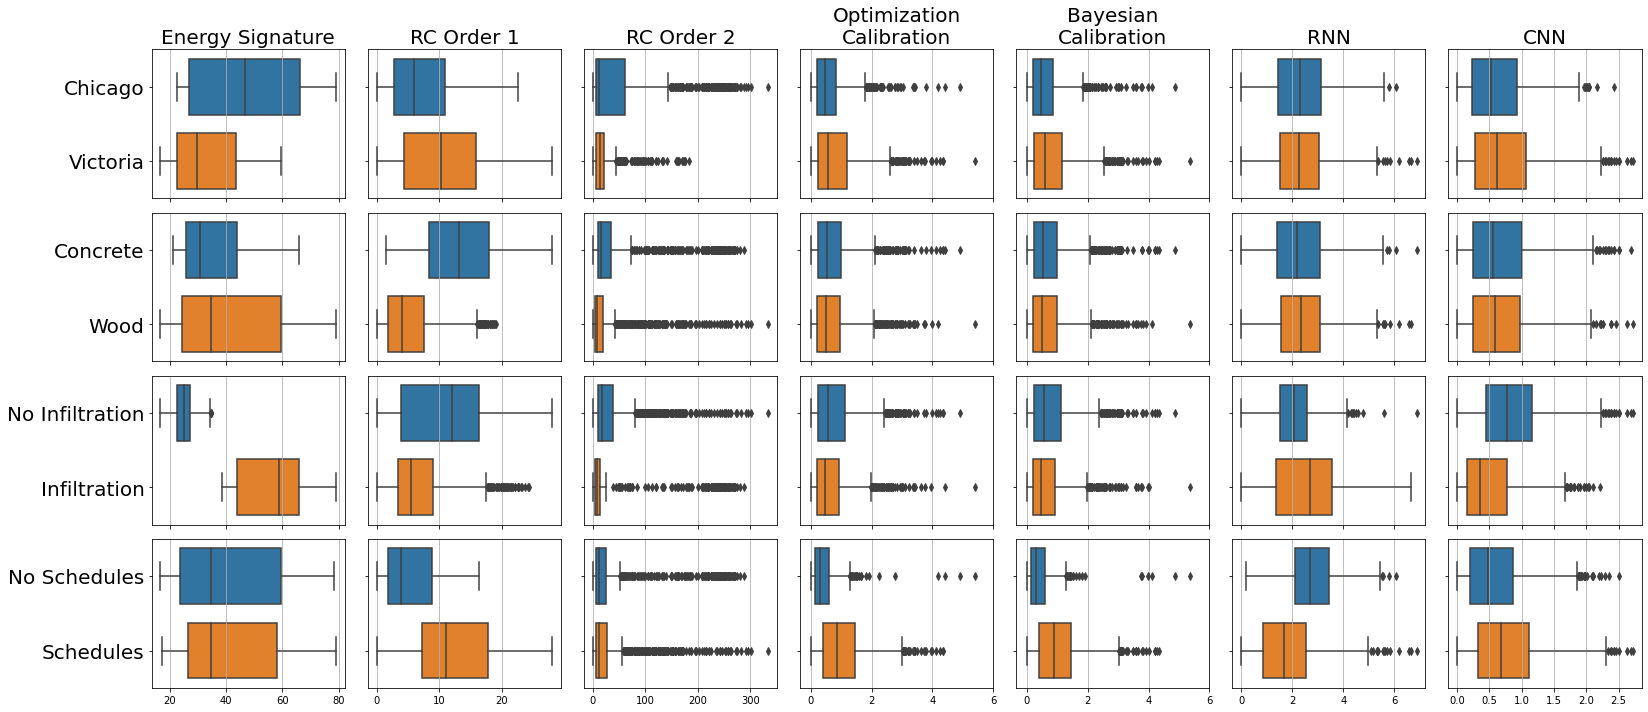

In [165]:
cases_box = ['weather', 'construct', 'infil', 'sched']
def create_boxplots_by_case(figsize=(23,10)):
    upper = 7

    fig, axes = plt.subplots(4, upper, sharey='row', sharex='col', figsize=figsize)

    i, j = 0,0
    
    for name, results in named_results.items():
        if results is not None:

            df_errs_all = pd.DataFrame()
            order = []
            for case, df in results.items():
                df_errors = pd.DataFrame()
                df_errors['errs'] = df['abs_err']
                case_name = case_string(case)
                df_errors = add_case_to_df(df_errors, case)
                df_errs_all = df_errs_all.append(df_errors)

            for y, yname in zip(cases_box,  ['Weather', 'Construction', 'Infiltration', 'Schedules']):
                p1=sns.boxplot(x='errs', y=y, data=df_errs_all, ax=axes[i, j], width=0.75)

                p1.xaxis.grid()
                p1.set_xlabel('', fontsize=0)
                if 'Calibration' in name:
                    p1.set_xlim((-0.35, 6))
                
                if j==0:
                    p1.set_ylabel('', fontsize=20)
                    p1.set_yticklabels(['Chicago', 'Victoria'], fontsize=20)
                    
                else: p1.set_ylabel('', fontsize=0)

                if i ==0:
                    p1.set_title(name, fontsize=20)

                i+=1
                if i%4 == 0:
                    j+=1; i=0

    plt.setp(axes[0,0], yticklabels=['Chicago', 'Victoria'])
    plt.setp(axes[1,0], yticklabels=['Concrete', 'Wood'])
    plt.setp(axes[2,0], yticklabels=['No Infiltration', 'Infiltration'])
    plt.setp(axes[3,0], yticklabels=['No Schedules', 'Schedules'])
    
    plt.savefig('boxplots_by_case')
    plt.tight_layout()
    
    
create_boxplots_by_case()

In [13]:
print('test')

test


# TTests

In [150]:
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon

### Check Spread

Weather


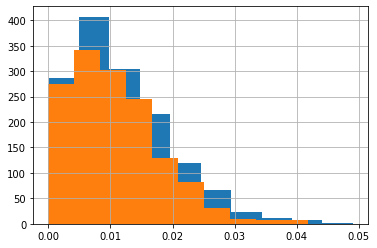

In [149]:
def check_spread(df):
    print('Weather')
    vdf = df[df['weather'] == 'victoria']
    cdf = df[df['weather'] == 'chicago']
    
    vdf['abs_err'].hist()
    cdf['abs_err'].hist()
#     print(tt, '\n')

#     print('Construction')
#     vdf = df[df['construct'] == 'wood']
#     cdf = df[df['construct'] == 'concrete']
#     tt = ttest_ind(vdf['abs_err'].tolist(), cdf['abs_err'].tolist())
#     print(tt, '\n')


#     print('Infiltration')
#     vdf = df[df['infil'] == 'True']
#     cdf = df[df['infil'] == 'False']
#     tt = ttest_ind(vdf['abs_err'].tolist(), cdf['abs_err'].tolist())
#     print(tt, '\n')


#     print('Schedule')
#     vdf = df[df['sched'] == True]
#     cdf = df[df['sched'] == False]
#     tt = ttest_ind(vdf['abs_err'].tolist(), cdf['abs_err'].tolist())
#     print(tt, '\n')

check_spread(cnn0_results_df)

In [ ]:
def ttest_Results(df):
    print('Weather')
    vdf = df[df['weather'] == 'victoria']
    cdf = df[df['weather'] == 'chicago']
#     pdb.set_trace()
    
    tt = ttest_ind(vdf['abs_err'].tolist(), cdf['abs_err'].tolist())
    mw = wilcoxon(vdf['abs_err'].tolist(), cdf['abs_err'].tolist())
    print(tt)
    print(mw, '\n')

    print('Construction')
    vdf = df[df['construct'] == 'wood']
    cdf = df[df['construct'] == 'concrete']
    tt = ttest_ind(vdf['abs_err'].tolist(), cdf['abs_err'].tolist())
    mw = wilcoxon(vdf['abs_err'].tolist(), cdf['abs_err'].tolist())
    print(tt)
    print(mw, '\n')


    print('Infiltration')
    vdf = df[df['infil'] == 'True']
    cdf = df[df['infil'] == 'False']
    tt = ttest_ind(vdf['abs_err'].tolist(), cdf['abs_err'].tolist())
    mw = wilcoxon(vdf['abs_err'].tolist(), cdf['abs_err'].tolist())
    print(tt)
    print(mw, '\n')


    print('Schedule')
    vdf = df[df['sched'] == True]
    cdf = df[df['sched'] == False]
    tt = ttest_ind(vdf['abs_err'].tolist(), cdf['abs_err'].tolist())
    mw = wilcoxon(vdf['abs_err'].tolist(), cdf['abs_err'].tolist())
    print(tt)
    print(mw, '\n')

In [ ]:
print('balance points=====================')
ttest_Results(bp_results_df)
print('decay cur =====================')
ttest_Results(dc_results_df)
print('\nRC =====================')
ttest_Results(rc_results_df)
print('\n RNN =====================')
ttest_Results(rnn0_results_df)
print('\nCNN =====================')
ttest_Results(cnn0_results_df)
print('\n')

balance points=====================
Weather
> <ipython-input-156-2b28ecbacfee>(7)ttest_Results()
-> tt = ttest_ind(vdf['abs_err'].tolist(), cdf['abs_err'].tolist())


(Pdb)  vdf


                                           fname    hlc_mat    hlc_tot  \
0    victoria_control_concrete_schedFalse_job158  57.790539  43.997100   
1     victoria_control_concrete_schedFalse_job11  73.261642  52.553078   
2    victoria_control_concrete_schedFalse_job177  85.288076  58.657029   
3     victoria_control_concrete_schedFalse_job72  55.304160  42.467077   
4    victoria_control_concrete_schedFalse_job107  64.649941  47.896298   
..                                           ...        ...        ...   
175   victoria_control_wood_inf_schedTrue_job182  60.508244  46.100403   
176    victoria_control_wood_inf_schedTrue_job81  70.286674  51.551248   
177    victoria_control_wood_inf_schedTrue_job46  73.685989  53.542716   
178    victoria_control_wood_inf_schedTrue_job64  54.370988  42.218328   
179   victoria_control_wood_inf_schedTrue_job110  59.286604  45.389221   

           hlc_se      hlc_si  hlc_inf_standard  hlc_inf_current  \
0    12670.832574  187.056476          0.00

(Pdb)  exit()


In [153]:
bp_results_df

fname    hlc_mat    hlc_tot  \
0    victoria_control_concrete_schedFalse_job158  57.790539  43.997100   
1     victoria_control_concrete_schedFalse_job11  73.261642  52.553078   
2    victoria_control_concrete_schedFalse_job177  85.288076  58.657029   
3     victoria_control_concrete_schedFalse_job72  55.304160  42.467077   
4    victoria_control_concrete_schedFalse_job107  64.649941  47.896298   
..                                           ...        ...        ...   
174    chicago_control_wood_inf_schedTrue_job122  69.604296  49.419864   
175    chicago_control_wood_inf_schedTrue_job148  73.630075  51.672884   
176    chicago_control_wood_inf_schedTrue_job115  57.120111  42.813365   
177    chicago_control_wood_inf_schedTrue_job188  84.702355  57.106440   
178    chicago_control_wood_inf_schedTrue_job182  60.508244  44.713257   

           hlc_se      hlc_si  hlc_inf_standard  hlc_inf_current  \
0    12670.832574  187.056476          0.000000         0.000000   
1    12671.812629  188.687855          0.000000         0.000000   
2    12672.818997  190.680392          0.000000         0.000000   
3    12669.745843  185.635435          0.000000         0.000000   
4    12671.392693  187.560815          0.000000         0.000000   
..            ...         ...               ...              ...   
174   1408.942981  193.869946         89.973957        90.867150   
175   1408.596258  197.582511         89.973957        90.796927   
176   1407.549432  194.561277         89.973957        90.810882   
177   1409.049067  200.183603         89.973957        90.785904   
178   1407.939008  195.015408         89.973957        90.794359   

     hlc_tot_pred  pred_err   abs_err                           case  \
0       22.121979 -6.260870  0.497195  victoriacontrol_concreteFalse   
1       30.034040 -7.182563  0.428501  victoriacontrol_concreteFalse   
2       36.384890 -7.546299  0.379701  victoriacontrol_concreteFalse   
3       20.560953 -6.377784  0.515838  victoriacontrol_concreteFalse   
4       24.310134 -6.597809  0.492442  victoriacontrol_concreteFalse   
..            ...       ...       ...                            ...   
174     67.033082 -3.324668  0.519110    chicagocontrol_wood_infTrue   
175     67.022834 -3.167911  0.526831    chicagocontrol_wood_infTrue   
176     61.967466 -3.061078  0.533333    chicagocontrol_wood_infTrue   
177     70.704608 -3.338247  0.519279    chicagocontrol_wood_infTrue   
178     62.755777 -3.044363  0.534063    chicagocontrol_wood_infTrue   

      weather construct  infil  sched  
0    victoria  concrete  False  False  
1    victoria  concrete  False  False  
2    victoria  concrete  False  False  
3    victoria  concrete  False  False  
4    victoria  concrete  False  False  
..        ...       ...    ...    ...  
174   chicago      wood   True   True  
175   chicago      wood   True   True  
176   chicago      wood   True   True  
177   chicago      wood   True   True  
178   chicago      wood   True   True  

[2876 rows x 15 columns]

# ANOVA

### Check Spread

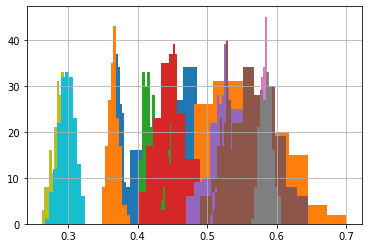

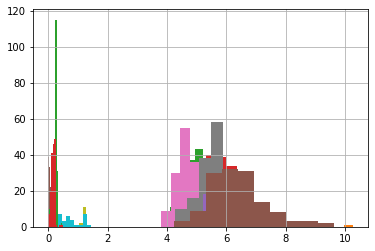

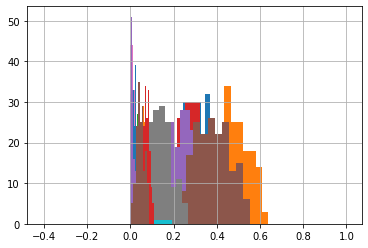

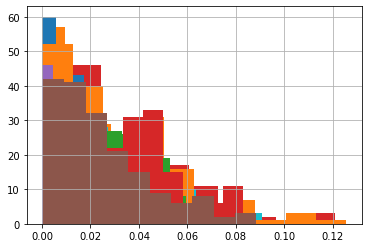

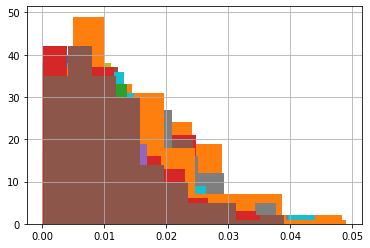

In [139]:
for r in all_result_dfs:
    for c in cases_all:
        rcase = r[r['case'] == case_string(c)]
        rcase['abs_err'].hist()
        
    plt.show()
    
#     lm = ols('abs_err ~ case', data=r).fit()
#     table = sm.stats.anova_lm(lm)
#     print(table, '\n')
#     print((table['mean_sq'])**0.5, '\n')
#     print(table['sum_sq']**0.5)

In [137]:
c

('chicago', 'control_wood_inf', True)

In [78]:
for r in all_result_dfs:
    lm = ols('abs_err ~ case', data=r).fit()
    table = sm.stats.anova_lm(lm)
    print(table, '\n')
    print((table['mean_sq'])**0.5, '\n')
#     print(table['sum_sq']**0.5)

              df     sum_sq   mean_sq            F  PR(>F)
case        15.0  25.023510  1.668234  3394.648103     0.0
Residual  2860.0   1.405492  0.000491          NaN     NaN 

case        1.291601
Residual    0.022168
Name: mean_sq, dtype: float64 

              df        sum_sq      mean_sq            F  PR(>F)
case        14.0  15288.622019  1092.044430  5555.411185     0.0
Residual  2056.0    404.154305     0.196573          NaN     NaN 

case        33.046096
Residual     0.443366
Name: mean_sq, dtype: float64 

              df     sum_sq   mean_sq            F  PR(>F)
case        14.0  56.193383  4.013813  1978.441512     0.0
Residual  2501.0   5.073967  0.002029          NaN     NaN 

case        2.003450
Residual    0.045042
Name: mean_sq, dtype: float64 

              df    sum_sq   mean_sq          F         PR(>F)
case        15.0  0.248309  0.016554  69.464295  3.902852e-180
Residual  2860.0  0.681563  0.000238        NaN            NaN 

case        0.128662
Residual 

In [38]:
166**0.5

12.884098726725126

In [41]:
table['mean_sq']**0.5

case        37.754398
Residual     0.280580
Name: mean_sq, dtype: float64

Can think of interpreting this as, for balance points there is an error of 12% that can be attributed to the different cases

# Contrasts

In [44]:
from patsy.contrasts import ContrastMatrix

def _name_levels(prefix, levels):
    return ["[%s%s]" % (prefix, level) for level in levels]

class Simple(object):
    def _simple_contrast(self, levels):
        nlevels = len(levels)
        contr = -1./nlevels * np.ones((nlevels, nlevels-1))
        contr[1:][np.diag_indices(nlevels-1)] = (nlevels-1.)/nlevels
        return contr

    def code_with_intercept(self, levels):
        contrast = np.column_stack((np.ones(len(levels)),
                                    self._simple_contrast(levels)))
        return ContrastMatrix(contrast, _name_levels("Simp.", levels))

    def code_without_intercept(self, levels):
        contrast = self._simple_contrast(levels)
        return ContrastMatrix(contrast, _name_levels("Simp.", levels[:-1]))

In [45]:
contrast = Simple().code_without_intercept(cases_all)
print(contrast.matrix)

[[-0.0625 -0.0625 -0.0625 -0.0625 -0.0625 -0.0625 -0.0625 -0.0625 -0.0625
  -0.0625 -0.0625 -0.0625 -0.0625 -0.0625 -0.0625]
 [ 0.9375 -0.0625 -0.0625 -0.0625 -0.0625 -0.0625 -0.0625 -0.0625 -0.0625
  -0.0625 -0.0625 -0.0625 -0.0625 -0.0625 -0.0625]
 [-0.0625  0.9375 -0.0625 -0.0625 -0.0625 -0.0625 -0.0625 -0.0625 -0.0625
  -0.0625 -0.0625 -0.0625 -0.0625 -0.0625 -0.0625]
 [-0.0625 -0.0625  0.9375 -0.0625 -0.0625 -0.0625 -0.0625 -0.0625 -0.0625
  -0.0625 -0.0625 -0.0625 -0.0625 -0.0625 -0.0625]
 [-0.0625 -0.0625 -0.0625  0.9375 -0.0625 -0.0625 -0.0625 -0.0625 -0.0625
  -0.0625 -0.0625 -0.0625 -0.0625 -0.0625 -0.0625]
 [-0.0625 -0.0625 -0.0625 -0.0625  0.9375 -0.0625 -0.0625 -0.0625 -0.0625
  -0.0625 -0.0625 -0.0625 -0.0625 -0.0625 -0.0625]
 [-0.0625 -0.0625 -0.0625 -0.0625 -0.0625  0.9375 -0.0625 -0.0625 -0.0625
  -0.0625 -0.0625 -0.0625 -0.0625 -0.0625 -0.0625]
 [-0.0625 -0.0625 -0.0625 -0.0625 -0.0625 -0.0625  0.9375 -0.0625 -0.0625
  -0.0625 -0.0625 -0.0625 -0.0625 -0.0625 -0.0625]


In [49]:
mod = ols("abs_err ~ C(case, Simple)", data=all_result_dfs[0])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                abs_err   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     3395.
Date:                Tue, 26 May 2020   Prob (F-statistic):               0.00
Time:                        06:07:41   Log-Likelihood:                 6882.1
No. Observations:                2876   AIC:                        -1.373e+04
Df Residuals:                    2860   BIC:                        -1.364e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

In [51]:
all_result_dfs[0]['abs_err'].mean()

0.4629195978992645

In [60]:
s = res.summary()

In [70]:
s.tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

# Factor Analysis

In [72]:
from statsmodels.multivariate.factor import Factor

In [73]:
mod = Factor("abs_err ~ C(case, Simple)", data=all_result_dfs[0])
res = mod.fit()
print(res.summary())

TypeError: __init__() got an unexpected keyword argument 'data'